# Exercise Classification during walking, running and biking

## Summary

This project make use of the "Wrist PPG During Exercise" dataset in physionet

https://physionet.org/content/wrist/1.0.0/

This dataset contains wrist PPGs, accelerometers and gyroscopes recorded during walking, running and bike riding. The data was recorded from 8 participants (3 male, 5 female), aged 22--32 (mean 26.5). 

This project is only using the accelerometers data to classify activities between walking, running and low resistance biking.

This project was inspired by an exercise from a Udacity course (https://github.com/udacity/nd320-c4-wearable-data-starter/tree/master/activity-classifier) which was conveniently copied under (https://github.com/DidierAll/Activity_Classification-Biking/CourseFiles). However, I have made some major additional contributions and changes to the original projects including
1. A more detailed data exploration with additional violin plots
2. Corrected mistakes made to the feature extraction (dominant power freq calculation dom_x in "activity_classifier_utils.py" functions
3. Modified and reprogrammed most of the codes (in particular the nested logo cross-validation) using scikit-learn native functions such as gridsearch, ConfusionMatrixDisplay, cross_valid_score/predict. 
4. Modified the tree depth parameter range from 2 to 7 to 1 to 6. This in itself improved the generalized test performance from the nested logo cross-validation from 76% to 92% 
5. Added and coded a "modified nested logo cross-validation"
6. Added a classification performance visualization using PCA and t-NSE with a more in depth discussion of the results 

## Data Exploration 

First let's explore the data...

### Imports

In [319]:
import collections
import glob
import os

from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import scipy as sp
import scipy.signal
import seaborn as sns

### Examine The Files

In [320]:
data_dir = 'data/'
filenames = [os.path.splitext(f)[0] for f in sorted(os.listdir(data_dir))]
fs = 256
print('Number of files: ' + str(len(filenames)))
filenames

Number of files: 17


['s1_bike_0',
 's1_bike_1',
 's1_walk',
 's2_bike_0',
 's2_bike_1',
 's2_walk',
 's3_bike_0',
 's3_bike_1',
 's3_run',
 's3_walk',
 's4_run',
 's5_run',
 's6_run',
 's6_walk',
 's8_run',
 's8_walk',
 's9_walk']

In [321]:
subjects_per_class = collections.defaultdict(set)
for f in filenames:
    subject = f.split('_')[0]
    activity = f.split('_')[1]
    subjects_per_class[activity].add(subject)
    
{k: len(v) for k, v in subjects_per_class.items()}

{'bike': 3, 'walk': 6, 'run': 5}

In summary, we have 17 files organized by subject_activity.  

Some subjects have two bike datasets  
First 2 subjects have no run  
S3 is the only one that has all 4 classes  
S4 and S5 only have run  
S6 and S8 don't have bike  
S9 only has walk

The main concerns are
1. The number of subjects is low (N=8)
2. Not all subjects have performed all 3 activities with an imbalance in terms of number of representation of each class per subject. Thish may leads to some problems during the leave-one-subject-out cross validation. Our models could be biased towards the class that occurs more often in the training set. 

 

### Load the data

In [322]:
subjects_per_class = collections.defaultdict(set)
# data creates a list of [subject, activity, accelerometer data]
data = []
# df_data will hold the restructured data in a single dataframe table
# to be used with seaborn plotting functions
df_data = [] 
for f in filenames:
    subject = f.split('_')[0]
    activity = f.split('_')[1]
    subjects_per_class[activity].add(subject)
    path = os.path.join(data_dir, f + '.csv')
    df = pd.read_csv(path)
    df = df.loc[: df.last_valid_index()]
    data.append((subject, activity, df))
    df_tmp = pd.melt(df,var_name='directions',value_name='acc')
    df_tmp = pd.concat([pd.DataFrame({'subject': np.repeat(subject,len(df_tmp)),'activity': np.repeat(activity,len(df_tmp))}),
                        df_tmp],axis=1)
    if len(df_data)==0:
        df_data=df_tmp
    else: 
        df_data = pd.concat([df_data,df_tmp],ignore_index='True')
    


Provide a descriptive statistics on the duration of the recordings

In [323]:
# descriptive stats on duration of each recording
print(sp.stats.describe([len(df[2])/60/fs for df in data]))

df.head()

DescribeResult(nobs=17, minmax=(3.65, 9.8), mean=6.087051930147059, variance=3.701484939724792, skewness=1.0699974180917178, kurtosis=-0.14716069171995239)


,accx,accy,accz
0,3.791152,-9.329793,1.622757
1,3.791152,-9.329285,1.646969
2,3.791366,-9.304383,1.695834
3,3.767274,-9.267029,1.732482
4,3.780279,-9.194481,1.770231


Each Recording is about 4-10 min long!

Plot the number of datapoints per class to get a better idea of the class imbalance.

In [324]:
%matplotlib inline

Text(0.5, 1.0, 'Number of samples per activity')

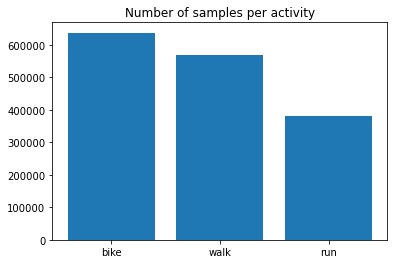

In [325]:
samples_per_class = collections.defaultdict(int)
for subject, activity, df in data:
    samples_per_class[activity] += len(df)
    

activity, n_samples = list(zip(*samples_per_class.items()))
plt.figure(figsize=(6, 4))
plt.bar(range(3), n_samples)
plt.xticks(range(3), activity);
plt.title('Number of samples per activity')

Plot distribution of the data

<Figure size 432x288 with 0 Axes>

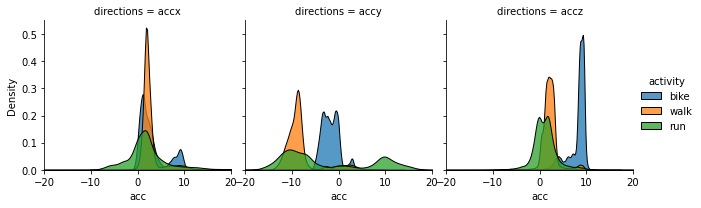

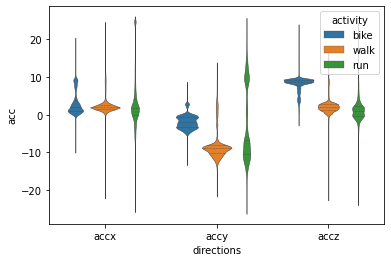

In [326]:
# Plotting by combining subjects data
plt.figure(figsize=(6, 4))
g = sns.FacetGrid(df_data.drop(columns=["subject"]), col="directions", hue="activity")
g.map(sns.kdeplot, "acc", multiple="stack")
g.add_legend()
g.set(xlim=(-20, 20))

plt.figure(figsize=(6, 4))
ax = sns.violinplot(x="directions", y="acc", hue="activity",
                    data=df_data.drop(columns=["subject"]),inner='quartile', width=0.8, linewidth=0.5)


## Plotting the Raw Data

First, let's plot the raw data for a particular subject (subject s3)

In [327]:
%matplotlib inline

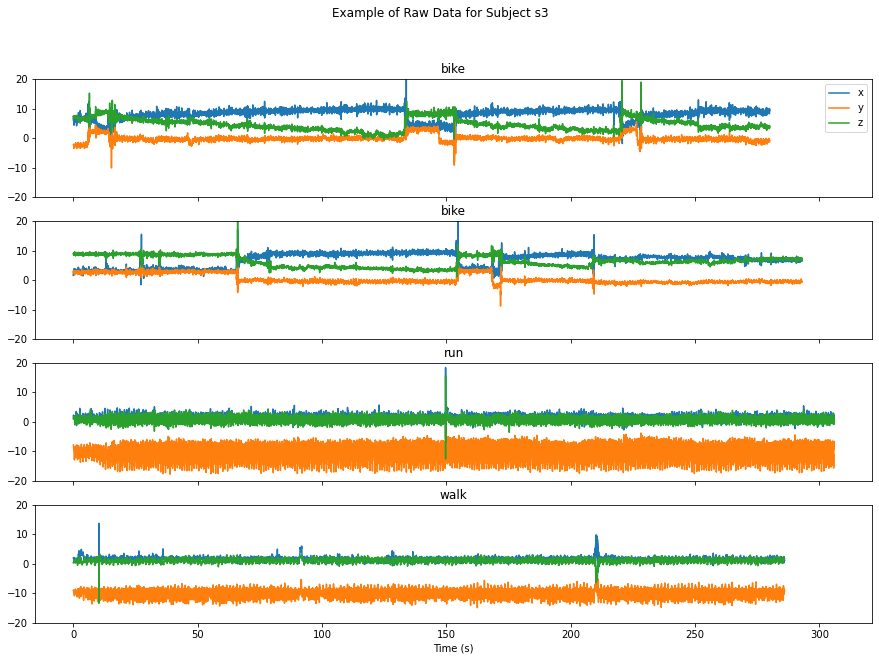

In [328]:

fig = plt.figure(figsize=(15, 10))
axs = fig.subplots(4, sharex=True, sharey=True)

i = 0
fig.suptitle('Example of Raw Data for Subject s3')
for subject, activity, df in sorted(data[6:10], key=lambda x: x[1]):
    ts = np.arange(len(df)) / fs
    axs[i].plot(ts, df.accx, label='x')
    axs[i].plot(ts, df.accy, label='y')
    axs[i].plot(ts, df.accz, label='z')
    axs[i].set_title('{}'.format(activity))
    if i == 0:
        axs[i].legend()
    #
    i = i + 1

axs[3].set_ylim((-20, 20))
axs[3].set_xlabel('Time (s)')
plt.draw()
# hide x-axis label
for ax in axs:
    ax.label_outer()

As one can see, signal amplitude varies a lot between activities. Also, there seem to be some large dis  

Now, let's use a magic function to have an interactive plot to be able to plot, zoom in and look more carefully at each recordings; must press a key to go to next recording

In [329]:
%matplotlib auto


Using matplotlib backend: Qt5Agg


In [330]:
for subject, activity, df in sorted(data, key=lambda x: x[1]):
    ts = np.arange(len(df)) / fs
    plt.clf() 
    plt.plot(ts, df.accx, label='x')
    plt.plot(ts, df.accy, label='y')
    plt.plot(ts, df.accz, label='z')
    plt.title('{} - {}'.format(subject.split('_'), activity))
    plt.legend()
    plt.ylim((-25, 25))
    plt.draw() 
    plt.show()
    #plt.pause(10)
    # wait for user input (key); can still use mouse button
    while not plt.waitforbuttonpress(timeout=1):
        pass

### Observations

In summary, for some recordings, data shows large discontinuity so mean of the data may not be a useful feature (?). High pass filtering may be necessary and features may need to be independent of offset/mean. The signal amplitude and frequency varies between activities as it is to be expected. 

## Activity Classification

We are now building a random forest classifier to classify activity between bike, walk and run. This will be accomplished by creating features on 10s data segments.

In terms of features, we will be computing time related measures (amplitude, standard deviation, power), data distributions measures (percentile values), as well as frequency related measures (fft, dominant frequency, spectral power and related distribution measures by computing freq related percentile values) for each axis and total accelerations.

We will tune the model by computing its performance for a range of values of the following 2 main hyperparameters: 
- the maximum  number of levels in each decision tree (max_tree_depth_opt ranging form 1 to 7) 
- the number of trees in the forest (n_estimators_opt ranging from 2 to 300)

Traditionally, for small and medium size data, this can be accomplished using the k-fold Nested Cross Validation (CV) technique. The procedure has been shown to give a less optimistic estimate of model performance on small training datasets than a single train/test split. 
Thnested CV approach uses nested loops where the inner loop is used to find the best hyperparameters for best performance, and the outer loop used to compute the unbiased performance of the best model. 

This is accomplished by first slipping the data into k1 groups. In each fold of the outer loop, one of the k1 group is held out (test set) to compute the generalized performance of the "best" performing model (resulting from the inner loop process) which was trained on the remaining k1-1 groups data (training+validation set).

For each of those outer loop fold, the evaluation of each set of hyperparameters is performed using another k2-fold CV that splits up the provided training+validation dataset into k2 groups. In each fold of the inner loop, one of the k2 group is being held out (validation set) to compute the performance of the model, while the remaining k2-1 groups data (training set) is used train the model. This training and performance calculation is performed for all pair of parameters in the hyperparameters space (grid search approach) and each k2 fold of the inner loop. The best model and associated hyperparameters are chosen using the best average performance across the k2-fold CV runs. 

Some important points:
- this nested CV method is used to estimate the generalized performance (mean and standard derivation) of the algorithm (CV and grid search to find the best model/hyperparameters). It is actually not used to compute the final model! This information can be used to compare and choose the best algorithm among several classifier methods. 
- the final model is actually computed by applying the inner loop procedure once to the entire dataset. The hyperparameters found during this final search are then used to configure a final model that is fit on the entire dataset. 

Given that the data are organized in groups of dependent data for each subject, the data split should be performed in groups. However given the small sample size (8 subjects), we will use the leave one group out (logo) CV method which is the group version of the Leave-One-Out Cross-Validation (LOOCV), an extreme case of the k-fold CV where the data is split into k= total number of sample.

Originally, per the course instructions and classic nested loop, the choice of best hyperparameters was computed at each outer loop. However different best parameters were found at each loop  

More information on the k-fold CV and LOOCV can be found in 
https://scikit-learn.org/stable/modules/cross_validation.html
https://machinelearningmastery.com/nested-cross-validation-for-machine-learning-with-python/
https://machinelearningmastery.com/loocv-for-evaluating-machine-learning-algorithms/

### Grid search using the Classic Nested CV logo

In [331]:
# reverting to inline plotting
%matplotlib inline

In [332]:
import os

from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import scipy as sp
import scipy.signal
import scipy.stats
import itertools
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

import activity_classifier_utils

In [333]:
fs = 256
data = activity_classifier_utils.LoadWristPPGDataset()
labels, subjects, features = activity_classifier_utils.GenerateFeatures(data, fs, window_length_s=10, window_shift_s=10)

class_names = np.array(['bike', 'run', 'walk'])

Parameter tuning using the classic nested logo CV algorithm. We are displaying the best model/parameters and its performance at each outer loop of the nested logo CV 

In [334]:
#grid = dict()
grid = {'n_estimators' : [2, 10, 20, 50, 100, 150, 300],'max_depth' : np.array(range(1, 7))}
#grid['n_estimators'] = [2, 10, 20, 50, 100, 150, 300]
#grid['max_depth'] = np.array(range(1, 7))
#gs = GridSearchCV(clf, grid, cv=logo)

logo = LeaveOneGroupOut()
splitlist = list(logo.split(features, labels, subjects))

accuracy_test = list()
accuracy_table = []
best_parameters_table = []
nested_cv_cm = np.zeros((3, 3), dtype='int')
nested_cv_cm_val = np.zeros((3, 3), dtype='int')

#for (train_val_ind, test_ind) in logo.split(features, labels, subjects):
for indx1, (train_val_ind, test_ind) in enumerate(splitlist):
    print('Outer loop running split {}'.format(indx1+1))
    
    X_train_val, y_train_val = features[train_val_ind], labels[train_val_ind]
    subjects_train_val = subjects[train_val_ind]
    X_test, y_test = features[test_ind], labels[test_ind]
    subjects_test = subjects[test_ind]
    # define the model
    model = RandomForestClassifier(random_state=42, class_weight='balanced')
    # define search
    search = GridSearchCV(model, grid, scoring='accuracy', cv=logo, refit=True)
    # execute search
    result = search.fit(X_train_val, y_train_val,groups=subjects_train_val)
    # get the best performing model fit on the whole training set
    best_clf = result.best_estimator_
    # evaluate model on the hold out dataset
    y_pred = best_clf.predict(X_test)
    # evaluate the model
    acc = accuracy_score(y_test, y_pred)
    # store the result
    accuracy_test.append(acc)
    # report progress
    print('Group Out=%s, acc=%.3f, est=%.3f, best parameters = [max_depth=%s, n_estimators=%s]' % 
          (subjects_test[0],acc, result.best_score_, result.best_params_['max_depth'],result.best_params_['n_estimators']))

    # Aggregate confusion matrices for each CV fold.
    c = confusion_matrix(y_test, y_pred, labels=class_names)
    nested_cv_cm += c
    
    yval_pred = best_clf.predict(X_train_val)
    c2 = confusion_matrix(y_train_val, yval_pred, labels=class_names) 
    nested_cv_cm_val += c2
    
    best_parameters_table.append((result.best_params_['max_depth'],result.best_params_['n_estimators']))
    # store parameters and performances for outerloop
    accuracy_table.append(
        (best_clf.score(X_train_val, y_train_val),best_clf.score(X_test, y_test),
        subjects_test[0],
        sum(y_test==class_names[0]),sum(y_test==class_names[1]),sum(y_test==class_names[2]),
        sum(y_train_val==class_names[0]),sum(y_train_val==class_names[1]),sum(y_train_val==class_names[2])))     

# summarize the estimated performance of the model
accuracy_trainval = [i[0] for i in accuracy_table]
print('\nGeneralized Accuracy of the nested logo CV: %.3f (%.3f)' % (np.mean(accuracy_test), np.std(accuracy_test)))
print('Total Average outer loop training Accuracy: %.3f (%.3f)\n' % (np.mean(accuracy_trainval), np.std(accuracy_trainval)))

Outer loop running split 1
Group Out=s1, acc=0.994, est=0.878, best parameters = [max_depth=1, n_estimators=300]
Outer loop running split 2
Group Out=s2, acc=0.947, est=0.882, best parameters = [max_depth=1, n_estimators=150]
Outer loop running split 3
Group Out=s3, acc=0.921, est=0.917, best parameters = [max_depth=1, n_estimators=300]
Outer loop running split 4
Group Out=s4, acc=1.000, est=0.898, best parameters = [max_depth=1, n_estimators=10]
Outer loop running split 5
Group Out=s5, acc=1.000, est=0.881, best parameters = [max_depth=2, n_estimators=300]
Outer loop running split 6
Group Out=s6, acc=0.508, est=0.982, best parameters = [max_depth=1, n_estimators=300]
Outer loop running split 7
Group Out=s8, acc=0.985, est=0.898, best parameters = [max_depth=1, n_estimators=300]
Outer loop running split 8
Group Out=s9, acc=0.952, est=0.904, best parameters = [max_depth=1, n_estimators=300]

Generalized Accuracy of the nested logo CV: 0.913 (0.156)
Total Average outer loop training Accu

Let's look more closely at each CV outer loop:


Accuracy and best parameters and corresponding training/test set information for each outer loop test runs 

   max_depth  n_estimators  Val. acc.  Test acc. Group out Ntest(bike|run|walk) Ntrain(bike|run|walk)
1          1           300       0.92       0.99        s1             115|0|58           130|147|161
2          1           150       0.94       0.95        s2              74|0|39           171|147|180
3          1           300       0.93       0.92        s3             56|30|28           189|117|191
4          1            10       0.93       1.00        s4               0|29|0           245|118|219
5          2           300       0.96       1.00        s5               0|30|0           245|117|219
6          1           300       0.99       0.51        s6              0|30|33           245|117|186
7          1           300       0.94       0.99        s8              0|28|40           245|119|179
8          1           300       0.93       0.95        s9               0

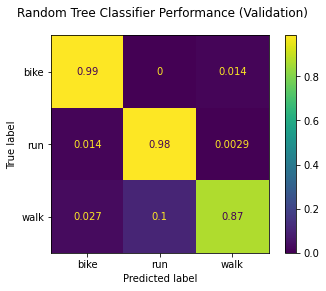

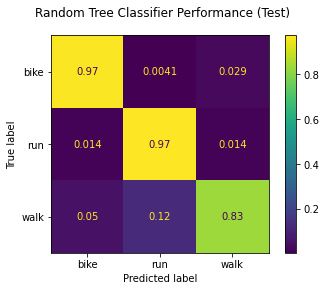

In [335]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import pandas as pd
n_estimators_opt = [2, 10, 20, 50, 100, 150, 300]
max_tree_depth_opt = np.array(range(1, 7)) 

# creating dataframe after rounding out accuracy values
pd1 = pd.DataFrame(best_parameters_table, 
                                 columns=['max_depth','n_estimators'],
                                 index=np.arange(1,len(best_parameters_table)+1))
pd2 = pd.DataFrame([np.round(i[:2],2) for i in accuracy_table],
                                 columns=['Val. acc.', 'Test acc.'],
                                 index=np.arange(1,len(accuracy_table)+1))

pd3 = pd.DataFrame([[i[2], str(i[3])+'|'+str(i[4])+'|'+str(i[5]), str(i[6])+'|'+str(i[7])+'|'+str(i[8])] for i in accuracy_table] ,
                                 columns=['Group out',
                                          'Ntest(bike|run|walk)',
                                          'Ntrain(bike|run|walk)'],
                                 index=np.arange(1,len(accuracy_table)+1))

accuracy_table_df = pd.concat([pd1,pd2,pd3], axis=1)
#We do not have access to accuracy_val (inner loop accuracy validation for each pair of hyperparameters); commented out
#accuracy_validation_table_df = pd.DataFrame(np.round(accuracy_val,2),
#                                            index=[str(a) for a in n_estimators_opt],
#                                            columns=[str(a) for a in max_tree_depth_opt])

pd.set_option('expand_frame_repr', False) # to show each rwo in one line
print('\nAccuracy and best parameters and corresponding training/test set information for each outer loop test runs \n')
print(accuracy_table_df)

#print('Average accuracy for each pairs of hyperparameters')
#print(accuracy_validation_table_df)
#print('Total Average Test Accuracy= {:0.2f}'.format(np.sum(np.diag(nested_cv_cm)) / np.sum(np.sum(nested_cv_cm))))

nested_cv_cm_norm = np.array([[nested_cv_cm[i,j]/sum(nested_cv_cm[i,:]) for j in range(3)] for i in range(3)])
nested_cv_cm_val_norm = np.array([[nested_cv_cm_val[i,j]/sum(nested_cv_cm_val[i,:]) for j in range(3)] for i in range(3)])

disp = ConfusionMatrixDisplay(confusion_matrix=nested_cv_cm_val_norm, display_labels=class_names)
disp.plot()
disp.figure_.suptitle("Random Tree Classifier Performance (Validation)");

disp2 = ConfusionMatrixDisplay(confusion_matrix=nested_cv_cm_norm, display_labels=class_names)
disp2.plot()
disp2.figure_.suptitle("Random Tree Classifier Performance (Test)");


#### _Observations_

An important observation from the outer loop runs, is that performance accuracy is greater than that of the estimated accuracy except for split 6. This may be counter intuitive, but the results of not having all activities performed by all subject. 

Each outer loop split compute the performance on one hold out subject who may have performed only one or two activities which may lead, at times, to a perfect classification performance (see next).

As for split 6, where subject s6 was held out, the test performance is poor, suggesting that s6 may have very different data from the other subjects, resulting in a trained model that does not generalize well to s6. Indeed, the raw data for s6 walk as shown earlier showed large discontinuities and jumps. 

The overall generalized accuracy of the grid search approach based on the nested logo CV ends up to be 0.913 with a standard deviation of 0.156!

### Grid Search using a modified Nested logo CV algorithm

As we saw in the prior runs, the best hyperparameters/model change at each outer loop.

To avoid this issue, an alternate way would be to compute first the average performance on the validation sets across each outer loop runs for each pair of parameters to find the best hyperparameters/model, before using this to compute the generalized accuracy.
<br>The issue with this approach is that you need to run the outer loop twice: once to compute the validation accuracy for each pairs of parameters and deduce the best hyperparameters/model and a second time to train the best model on the training+validation set and compute the accuracy on the test set of/the held out group (subject). 
<br> This requires a manual implementation of the nested logo CV algorithm.

In [336]:
#%% PARAMETER TUNING BASED ON TRAIN, VALIDATION, TEST SETS USING NESTED LOOP
n_estimators_opt = [2, 10, 20, 50, 100, 150, 300]
max_tree_depth_opt = np.array(range(1, 7)) 

Ntest = logo.get_n_splits(features, labels, subjects)
# same as Ntest = len(np.unique(subjects))

# create a split list
logo = LeaveOneGroupOut()
splitlist = list(logo.split(features, labels, subjects))
classification_accuracy2 = np.zeros((Ntest, len(n_estimators_opt),len(max_tree_depth_opt)))

for indx1, (train_val_ind, test_ind) in enumerate(splitlist):
    # Split the dataset into a test set and a training + validation set.
    # Model parameters (the random forest tree nodes) will be trained on the training set.
    # Best Hyperparameters (how many trees and the max depth) will be trained based accuracy on the validation set.
    # Generalization error will be computed on the test set.        
    X_train_val, y_train_val = features[train_val_ind], labels[train_val_ind]
    subjects_train_val = subjects[train_val_ind]
    
    print('Running split {}'.format(indx1+1))
    
    for indx2, n_estimators in enumerate(n_estimators_opt):
        for indx3, max_tree_depth in enumerate(max_tree_depth_opt):
    #for n_estimators, max_tree_depth in itertools.product(n_estimators_opt,
    #                                                      max_tree_depth_opt):

            #print(str(indx1+1) + '/' + str(Ntest) + ' : (' + str(n_estimators) + ',' 
            #      + str(max_tree_depth) + ')'  )  

            # random_state=42 to have a deterministic behaviour during fitting 
            clf = RandomForestClassifier(n_estimators=n_estimators,
                                     max_depth=max_tree_depth,
                                     random_state=42,
                                     class_weight='balanced')
            # inner loop to train the model on the training set for a given set of hyperparameters
            inner_cm = np.zeros((3, 3), dtype='int') # inner loop confusion matrix (average accross runs)
            for train_ind, validation_ind in logo.split(X_train_val, y_train_val,
                                                    subjects_train_val):
                X_train, y_train = X_train_val[train_ind], y_train_val[train_ind]
                X_val, y_val = X_train_val[validation_ind], y_train_val[validation_ind]
                clf.fit(X_train, y_train)
                y_pred = clf.predict(X_val)
                c = confusion_matrix(y_val, y_pred, labels=class_names) 
                inner_cm += c
                
            # Store the accuracy (average across train+validation runs)
            classification_accuracy2[indx1,indx2,indx3] = np.sum(np.diag(inner_cm)) / np.sum(np.sum((inner_cm)))


Running split 1
Running split 2
Running split 3
Running split 4
Running split 5
Running split 6
Running split 7
Running split 8


In [337]:
# Find the best pair of hyperparameters by averaging classification accuracy
# across test runs for each pair of parameters
accuracy_val2 = np.mean(classification_accuracy2, axis=0)
(n1max, n2max) = np.unravel_index(accuracy_val2.argmax(),np.shape(accuracy_val2))
best_hyper_params2 = (n_estimators_opt[n1max], max_tree_depth_opt[n2max])
best_accuracy2 = accuracy_val2[n1max, n2max]
    
      
# Create a model with the best pair of hyperparameters for this training + validation set.
best_clf = RandomForestClassifier(n_estimators=best_hyper_params2[0],
                                      max_depth=best_hyper_params2[1], 
                                      random_state=42, class_weight='balanced')
    
#%% Finally, run the outer loop again and train this model and test it on the test set.
nested_cv_cm2 = np.zeros((3, 3), dtype='int')
nested_cv_cm_val2 = np.zeros((3, 3), dtype='int')
accuracy_table2 = []
splits = 0

for indx1, (train_val_ind, test_ind) in enumerate(splitlist):

    X_train_val, y_train_val = features[train_val_ind], labels[train_val_ind]
    subjects_train_val = subjects[train_val_ind]
    X_test, y_test = features[test_ind], labels[test_ind]
    subjects_test = subjects[test_ind]
    
    best_clf.fit(X_train_val, y_train_val)
    y_pred = best_clf.predict(X_test)
    
    # Aggregate confusion matrices for each CV fold.
    c = confusion_matrix(y_test, y_pred, labels=class_names)
    nested_cv_cm2 += c
    splits += 1

    yval_pred = best_clf.predict(X_train_val)
    c2 = confusion_matrix(y_train_val, yval_pred, labels=class_names) 
    nested_cv_cm_val2 += c2
    
    # store parameters and performances for outerloop
    accuracy_table2.append((best_clf.score(X_train_val, y_train_val),best_clf.score(X_test, y_test),
                           subjects_test[0],
                           sum(y_test==class_names[0]),sum(y_test==class_names[1]),sum(y_test==class_names[2]),
                           sum(y_train_val==class_names[0]),sum(y_train_val==class_names[1]),sum(y_train_val==class_names[2])))
    
accuracy_trainval2 = [i[0] for i in accuracy_table2]
accuracy_test2 = [i[1] for i in accuracy_table2]
print('Best Model: Max Depth (max_depth)=%s, Number of Trees in the Forest (n_estimators)=%s ' % (best_hyper_params2[1],best_hyper_params2[0]))      

print('\nTotal Average Generalized (Test) Accuracy: %.3f (%.3f)' % (np.mean(accuracy_test2), np.std(accuracy_test2)))
print('Total Average outer loop training Accuracy: %.3f (%.3f)\n' % (np.mean(accuracy_trainval2), np.std(accuracy_trainval2)))


Best Model: Max Depth (max_depth)=1, Number of Trees in the Forest (n_estimators)=300 

Total Average Generalized (Test) Accuracy: 0.913 (0.156)
Total Average outer loop training Accuracy: 0.939 (0.020)



Let's look more closely at each CV outer loop:

Best Model: Max Depth (max_depth)=1, Number of Trees in the Forest (n_estimators)=300 

Accuracy performance and corresponding training/test set information for each outer loop test runs 

   Val. acc.  Test acc. Group out Ntest(bike|run|walk) Ntrain(bike|run|walk)
1       0.92       0.99        s1             115|0|58           130|147|161
2       0.94       0.95        s2              74|0|39           171|147|180
3       0.93       0.92        s3             56|30|28           189|117|191
4       0.93       1.00        s4               0|29|0           245|118|219
5       0.93       1.00        s5               0|30|0           245|117|219
6       0.99       0.51        s6              0|30|33           245|117|186
7       0.94       0.99        s8              0|28|40           245|119|179
8       0.93       0.95        s9               0|0|21           245|147|198

Average accuracy for each pair of hyperparameters

        1     2     3     4     5     6
2    0.60  0.79  0.67  0.6

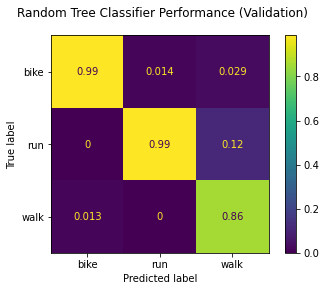

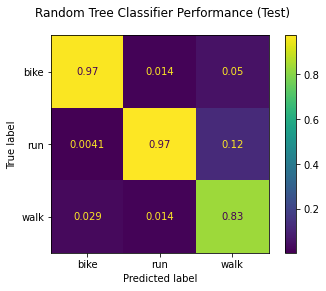

In [338]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import pandas as pd

# creating dataframe after rounding out accuracy values
pd12 = pd.DataFrame([np.round(i[:2],2) for i in accuracy_table2],
                                 columns=['Val. acc.', 'Test acc.'],
                                 index=np.arange(1,len(accuracy_table2)+1))

pd22 = pd.DataFrame([[i[2], str(i[3])+'|'+str(i[4])+'|'+str(i[5]),
                     str(i[6])+'|'+str(i[7])+'|'+str(i[8])] for i in accuracy_table2] ,
                                 columns=['Group out',
                                          'Ntest(bike|run|walk)',
                                          'Ntrain(bike|run|walk)'],
                                 index=np.arange(1,len(accuracy_table2)+1))

accuracy_table_df2 = pd.concat([pd12,pd22], axis=1)

pd.set_option('expand_frame_repr', False) # to show each row in one line

print('Best Model: Max Depth (max_depth)=%s, Number of Trees in the Forest (n_estimators)=%s ' % (best_hyper_params2[1],best_hyper_params2[0]))      

print('\nAccuracy performance and corresponding training/test set information for each outer loop test runs \n')
print(accuracy_table_df2)

accuracy_validation_table_df2 = pd.DataFrame(np.round(accuracy_val2,2),
                                            index=[str(a) for a in n_estimators_opt],
                                            columns=[str(a) for a in max_tree_depth_opt])

print('\nAverage accuracy for each pair of hyperparameters\n')
print(accuracy_validation_table_df2)

#print('\nTotal Average Generalized (Test) Accuracy= {:0.2f}\n'.format(np.sum(np.diag(nested_cv_cm2)) /
#                                                                      np.sum(np.sum(nested_cv_cm2))))
print('\nTotal Average Generalized (Test) Accuracy: %.3f (+/-%.3f)\n' % (np.mean(accuracy_test2), np.std(accuracy_test2)))

nested_cv_cm_norm2 = np.array([[nested_cv_cm2[i,j]/sum(nested_cv_cm2[i,:]) for i in range(3)] for j in range(3)])
nested_cv_cm_val_norm2 = np.array([[nested_cv_cm_val2[i,j]/sum(nested_cv_cm_val2[i,:]) for i in range(3)] for j in range(3)])

disp = ConfusionMatrixDisplay(confusion_matrix=nested_cv_cm_val_norm2, display_labels=class_names)
disp.plot()
disp.figure_.suptitle("Random Tree Classifier Performance (Validation)");

disp2 = ConfusionMatrixDisplay(confusion_matrix=nested_cv_cm_norm2, display_labels=class_names)
disp2.plot()
disp2.figure_.suptitle("Random Tree Classifier Performance (Test)");

# this uses the function from activity_classifier_utils
#activity_classifier_utils.PlotConfusionMatrix(nested_cv_cm, class_names,normalize="True",
#                                              title="Random Tree Classifier Performance (Test)")
#activity_classifier_utils.PlotConfusionMatrix(nested_cv_cm_val, class_names,normalize="True",
#                                              title="Random Tree Classifier Performance (Validation)")

Let's compare the test accuracy of both approaches

In [349]:
print(pd.concat([pd1,pd2,pd12], axis=1, keys=['Classic logo CV','Classic logo CV','Modified logo CV']))

print('Total Average outer loop training Accuracy for the modified nested logo CV: %.3f (+/- %.3f)' % (np.mean(accuracy_trainval2), np.std(accuracy_trainval2)))
print('Total Average outer loop training Accuracy for the classic nested logo CV: %.3f (+/- %.3f)\n' % (np.mean(accuracy_trainval), np.std(accuracy_trainval)))

print('\nTotal Average Generalized (Test) Accuracy for the modified nested logo CV: %.3f (+/- %.3f)' % (np.mean(accuracy_test2), np.std(accuracy_test2)))
print('Total Average Generalized (Test) Accuracy for the classic nested logo CV: %.3f (+/- %.3f)\n' % (np.mean(accuracy_test), np.std(accuracy_test)))


  Classic logo CV                                  Modified logo CV          
        max_depth n_estimators Val. acc. Test acc.        Val. acc. Test acc.
1               1          300      0.92      0.99             0.92      0.99
2               1          150      0.94      0.95             0.94      0.95
3               1          300      0.93      0.92             0.93      0.92
4               1           10      0.93      1.00             0.93      1.00
5               2          300      0.96      1.00             0.93      1.00
6               1          300      0.99      0.51             0.99      0.51
7               1          300      0.94      0.99             0.94      0.99
8               1          300      0.93      0.95             0.93      0.95
Total Average outer loop training Accuracy for the modified nested logo CV: 0.939 (+/- 0.020)
Total Average outer loop training Accuracy for the classic nested logo CV: 0.943 (+/- 0.021)


Total Average Generalized (Test

### Conclusion
In essence, the modified nested logo CV has exactly the same generalized test accuracy than that of the classic approach!! This is a little surprising as the classic nested logo CV picks the best and possibly a different model (different hyperparameters) at each outer loop.

However, when looking more closely, the best model (parameters=(1,300)) picked by the modified logo CV remains the best performing model for 5 out of 8 outer loop runs. In the remaining instances, the parameters are very close: we have (1,150) and (2,300) for the 2nd and 5th outer loop runs with a greater deviation for the 4th loop (1,10). However for the latter, there is perfect accuracy of 1 for subject s4, which may mean that predictive accuracy is pretty robust irrespective of the model.

So at the end, using the modified nested logo CV had more of an academic than a practical benefit. 

## Final Model

Now that we have computed an estimate of the generalized algorithm performance using a nested logo CV, namely the mean/std accuracy of the grid search approach, we can build our final model using one pass of the outerloop on the entire training data.
<br>Let's first build the model

In [340]:
## Building the model
from sklearn.metrics import ConfusionMatrixDisplay
#from sklearn.inspection import DecisionBoundaryDisplay # can't use; only available with scikit-learn 1.1

clf = RandomForestClassifier(random_state=42, class_weight='balanced')
# define search
search = GridSearchCV(clf, grid, scoring='accuracy', cv=logo, refit=True)
# execute search
result = search.fit(features, labels, groups=subjects)
# get the best performing model fit on the whole training set
best_clf = result.best_estimator_
# evaluate model on the whole  dataset
y_pred = best_clf.predict(features)
# evaluate the model
estimate_final = accuracy_score(labels, y_pred)

best_hyper_params = (result.best_params_['n_estimators'], result.best_params_['max_depth'])

Then compute and display the model performance

Final best model using full dataset and its performance:
Max Depth (max_depth)=1, Number of Trees in the Forest (n_estimators)=300 
Estimated accuracy (entire dataset)=0.941, Average estimated Accuracy from logo=0.913 (0.156)


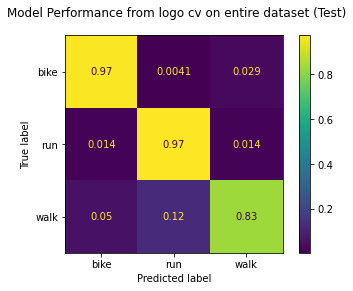

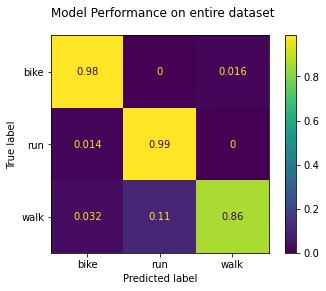

In [359]:
## Final model and its performance
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict

# Let's first rerun the crossvalidation on entire dataset for the best-clf to obtain logo accuracy 
# (technically same as modified nested logo cv test performance)
accuracy_test_final = cross_val_score(best_clf, features, labels, cv=logo, groups=subjects)
y_logo_pred = cross_val_predict(best_clf, features, labels, cv=logo, groups=subjects)


print('Final best model using full dataset and its performance:')
print('Max Depth (max_depth)=%s, Number of Trees in the Forest (n_estimators)=%s ' 
      % (result.best_params_['max_depth'],result.best_params_['n_estimators']))      
print('Estimated accuracy (entire dataset)=%.3f, Average estimated Accuracy from logo=%.3f (%.3f)' 
      % (estimate_final, np.mean(accuracy_test_final), np.std(accuracy_test_final)))
# This is another way to access mean/std from gridsearch
# print('Estimated accuracy (entire dataset)=%.3f, Average estimated Accuracy from logo=%.3f (%.3f)' 
#      % (result.cv_results_['mean_test_score'][np.argmax(result.cv_results_['mean_test_score'])],
#         result.cv_results_['std_test_score'][np.argmax(result.cv_results_['mean_test_score'])]))

# plot Confusion Matrix

disp = ConfusionMatrixDisplay.from_predictions(labels, y_logo_pred, normalize='true') 
disp.figure_.suptitle("Model Performance from logo cv on entire dataset (Test)");

disp = ConfusionMatrixDisplay.from_predictions(labels, y_pred, normalize='true') 
disp.figure_.suptitle("Model Performance on entire dataset");


So in essence, we end up with a final model with hyperparameters pair (1,300), which is similar to what the modified nested logo CV found. This is not too surprising given that this model was most constantly picked as the best model in the outer loop runs. 

It is important to emphasize again that the nested logo CV generalized accuracy (0.913 (+/- 0.156) which here is similar to the logo CV on entire dataset) is what to be used as robust generalized measure of performance of the grid search, rather than the estimated accuracy of 0.941 since the whole dataset is used to both train and compute the accuracy leading to an overly bias estimate.

The greatest challenge for the model has been to properly classify walk (acc=0.86) which has been in 11% of the cases wrongly labeled as run.

This can be better represented visually by plotting the decision regions and boundaries by projecting the high dimensional feaures space into 2 main components using the PCA and tSNE (t-distributed stochastic neighbor embedding) dimensionality reduction techniques. 

<class 'numpy.ndarray'>
(611, 2)
Explained variation per principal component: [0.96385592 0.02915143]
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 611 samples in 0.000s...
[t-SNE] Computed neighbors for 611 samples in 0.030s...


C:\Users\d_all\AppData\Local\Temp/ipykernel_10496/3502398193.py:33: UserWarning: The following kwargs were not used by contour: 'lw'
  plt.tricontourf(X_PCA[:,0],X_PCA[:,1],y_pred2,levels=[0.5,1.5],lw=0.5,cmap =  my_cmap, alpha =0.3,extend="both")
C:\Users\d_all\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\d_all\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computed conditional probabilities for sample 611 / 611
[t-SNE] Mean sigma: 347.774064
[t-SNE] KL divergence after 250 iterations with early exaggeration: 52.360291
[t-SNE] KL divergence after 300 iterations: 0.298174


C:\Users\d_all\AppData\Local\Temp/ipykernel_10496/3502398193.py:60: UserWarning: The following kwargs were not used by contour: 'lw'
  plt.tricontourf(X_tsne[:,0],X_tsne[:,1],y_pred2,levels=[0.5,1.5],lw=0.5,cmap =  my_cmap, alpha =0.3,extend="both")


Text(0.5, 1.0, 'Decision Boundary Using t-SNE')

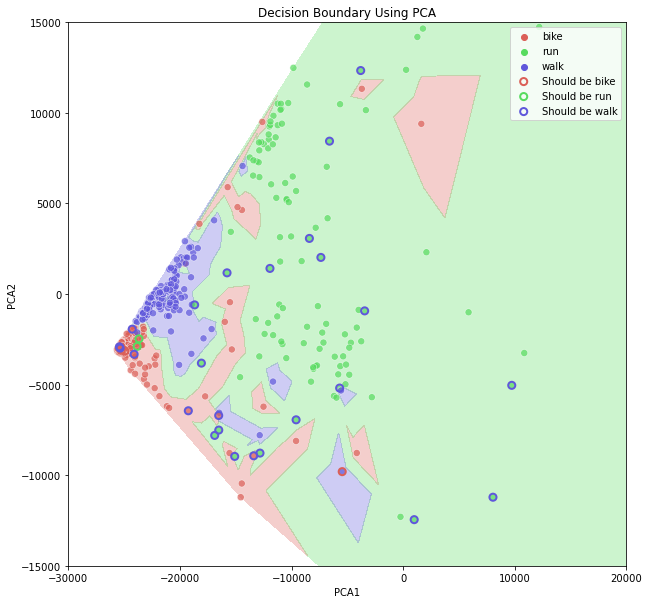

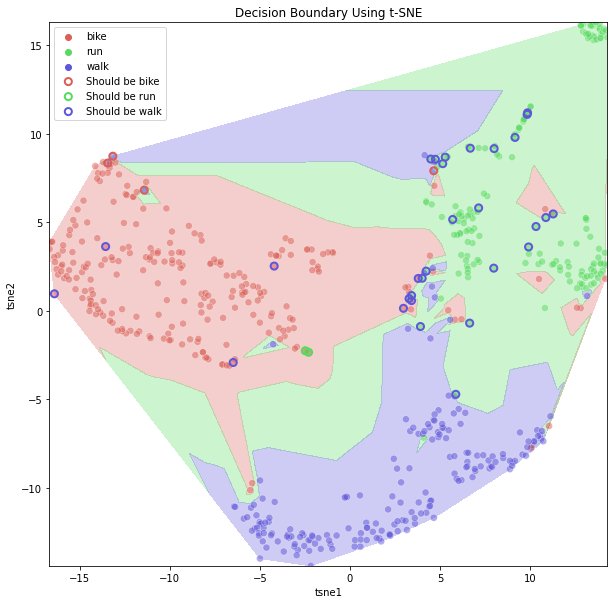

In [342]:
#from sklearn.inspection import DecisionBoundaryDisplay

import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from matplotlib.colors import ListedColormap

##### PCA projection to keep the top 2 components for 2D scatter plots

pca = PCA(n_components=2)
X_PCA = pca.fit(features).transform(features)
print(type(X_PCA))
print(X_PCA.shape)
print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_[:2]))

fig = plt.figure(figsize=(10, 10))
#DecisionBoundaryDisplay.from_estimator(best_clf, features, alpha=0.4, response_method="predict")

df_PCA = pd.DataFrame(X_PCA,columns=["PCA1","PCA2"]) 
palette = sns.color_palette("hls", 3)
hue_order = class_names

my_cmap = ListedColormap(palette.as_hex())

# plot first decision boundary regions by assigning 0 for bike, 1 for run and 2 for walk
# Note that the use of tricontourf to draw regions separated by th boundary 0.5 and 1.5 
# is not quite accurate as it forces to create a run/green (label =1) region between 
# bike/red (level 0) and bike/blue (level 2). To be fixed later... 
y_pred2 = np.empty(np.size(y_pred))
for i,label in enumerate(class_names):
    y_pred2[y_pred==label]=i

plt.tricontourf(X_PCA[:,0],X_PCA[:,1],y_pred2,levels=[0.5,1.5],lw=0.5,cmap =  my_cmap, alpha =0.3,extend="both")    

# then the predicted datapoints 
ax = sns.scatterplot(x="PCA1", y="PCA2",data=df_PCA,
                hue=y_pred, palette=palette,hue_order=hue_order,
                legend="full", s=50, alpha=0.7)
# finally highlight incorrectly labeled data with an outer colored edge around the marker
for i,label in enumerate(class_names): #= np.array(['bike', 'run', 'walk'])
    plt.scatter(X_PCA[(y_pred!=labels) & (labels==label), 0], X_PCA[(y_pred!=labels) & (labels==label), 1],
            s=50, facecolor = 'none', edgecolor=palette[i],marker="o",lw=2,label="Should be "+label)

ax.legend()
ax.set_title('Decision Boundary Using PCA')
#plt.xscale("log"); plt.yscale("log");
plt.xlim(-30000,20000);plt.ylim(-15000, 15000)



##### TSNE projection to keep the top 2 components for 2D scatter plots

tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300);
X_tsne = tsne.fit_transform(features)
df_tsne = pd.DataFrame(X_tsne,columns=["tsne1","tsne2"]) 

plt.figure(figsize=(10,10))

# plot first decision boundary regions
plt.tricontourf(X_tsne[:,0],X_tsne[:,1],y_pred2,levels=[0.5,1.5],lw=0.5,cmap =  my_cmap, alpha =0.3,extend="both")    

# then the predicted datapoints 

ax = sns.scatterplot(x="tsne1", y="tsne2",data=df_tsne,
                hue=y_pred, palette=palette,hue_order=hue_order,
                legend="full", s=50, alpha=0.5)

# finally highlight incorrectly labeled data with an outer colored edge around the marker
for i,label in enumerate(class_names): #= np.array(['bike', 'run', 'walk'])
    plt.scatter(X_tsne[(y_pred!=labels) & (labels==label), 0], X_tsne[(y_pred!=labels) & (labels==label), 1],
            s=50, facecolor = 'none', edgecolor=palette[i],marker="o",lw=2,label="Should be "+label)

ax.legend()
ax.set_title('Decision Boundary Using t-SNE')

As it can be seen, t-SNE seems to separate points much better than PCA. While PCA tries to separate points by keeping the 2 main components with the greatest variability using correlation, t-SNE tries to group points as close as possible based on their similarities information using joint probabilities. t-SNE does a better job at clustering points from the same class.

There are two main observations we can make:
- First, we see that "walk" data has more outlier points which leads to misclassification. It would be interesting to go back to the raw data to see if those data points corresponds to "noisy" recorded data.
- Second, we can find a few isolated data points especially for bike, which may mean that our model may be overfitting the data. It is unfortunately difficult to get a good generalizable model with limited data.


One way to address this issue is through regularization of our model by reducing the number of features to the top 10 best contributors to the model classification. 

Best model using full dataset and top 10 features:
Max Depth (max_depth)=300, Number of Trees in the Forest (n_estimators)=1 
Estimated accuracy (entire dataset)=0.953, Average estimated Accuracy from logo=0.908 (0.174)


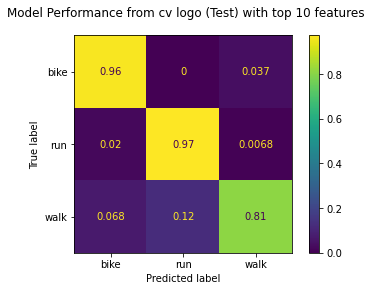

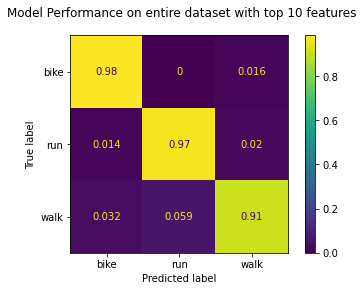

In [343]:
## create and compute a new model by keeping the top 10 features and original best_hyper_parameters (1,300)
# We will rerun the crossvalidation to obtain accuracy duing logo cv
clf10b = RandomForestClassifier(n_estimators=best_hyper_params[0], max_depth=best_hyper_params[1], 
                               random_state=42, class_weight='balanced')

# execute cross-validation
accuracy_test10b = cross_val_score(clf10b, features10, labels, cv=logo, groups=subjects)
y10b_logo_pred = cross_val_predict(clf10b, features10, labels, cv=logo, groups=subjects)

# evaluate model on the whole  dataset
result10b = clf10b.fit(features10, labels)
y10b_pred = clf10b.predict(features10)
# evaluate the model
estimate_final10b = accuracy_score(labels, y10b_pred)

## Final model and its performance
print('Best model using full dataset and top 10 features:')
print('Max Depth (max_depth)=%s, Number of Trees in the Forest (n_estimators)=%s ' 
      % (best_hyper_params[0],best_hyper_params[1]))      
print('Estimated accuracy (entire dataset)=%.3f, Average estimated Accuracy from logo=%.3f (%.3f)' 
      % (estimate_final10b, np.mean(accuracy_test10b), np.std(accuracy_test10b)))

disp = ConfusionMatrixDisplay.from_predictions(labels, y10b_logo_pred, normalize='true') 
disp.figure_.suptitle("Model Performance from cv logo (Test) with top 10 features");

disp = ConfusionMatrixDisplay.from_predictions(labels, y10b_pred, normalize='true') 
disp.figure_.suptitle("Model Performance on entire dataset with top 10 features");

This model sees a slight increase in overall accuracy when computed on the whole dataset from 0.94 to 0.95 but the generalized accuracy based on logo cv has slightly decreased from 0.913 to 0.908.

Let's see if this can be improved by re-performing a gridsearch given that by keeping the top 10 features may lead to different best parameters

In [344]:
## create and compute a new model by keeping the top 10 features and using a gridsearch to find best parameters

# create list of top 10 features and compute model using gridsearch
lst = sorted(list(zip(activity_classifier_utils.FeatureNames(), np.round(best_clf.feature_importances_,3))), key=lambda list2: list2[1], reverse=True)[:10]
df = pd.DataFrame(lst, columns =['Feature', 'Importances'],index=np.arange(1,len(lst)+1)) 
print(df)

sorted_features = sorted(zip(best_clf.feature_importances_, np.arange(len(best_clf.feature_importances_))), reverse=True)
best_feature_indices = list(zip(*sorted_features))[1]
features10 = features[:, best_feature_indices[:10]]

# perform a grid search to find the best model based on those 10 features
clf10 = RandomForestClassifier(random_state=42, class_weight='balanced')
# define search
search10 = GridSearchCV(clf10, grid, scoring='accuracy', cv=logo, refit=True)
# execute search on those 10 features
result10 = search10.fit(features10, labels, groups=subjects)
# get the best performing model fit on the whole training set
best_clf10 = result10.best_estimator_

# execute cross-validation on best model
accuracy_test10 = cross_val_score(best_clf10, features10, labels, cv=logo, groups=subjects)
y10_logo_pred = cross_val_predict(best_clf10, features10, labels, cv=logo, groups=subjects)

# evaluate model on the whole  dataset
y10_pred = best_clf10.predict(features10)
# evaluate the model
estimate_final10 = accuracy_score(labels, y10_pred)

best_hyper_params10 = (result10.best_params_['n_estimators'], result10.best_params_['max_depth'])


        Feature  Importances
1          p5_z        0.127
2         p10_z        0.097
3   energy_12_z        0.097
4   energy_34_z        0.097
5         p25_z        0.087
6   energy_45_z        0.083
7   energy_56_z        0.077
8   energy_23_z        0.063
9         std_y        0.043
10         mn_z        0.030


Best model using full dataset and top 10 features:
Max Depth (max_depth)=3, Number of Trees in the Forest (n_estimators)=10 
Estimated accuracy (entire dataset)=0.959, Average estimated Accuracy from logo=0.925 (0.142)


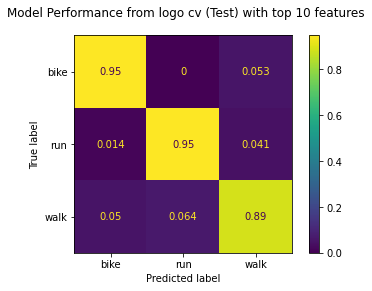

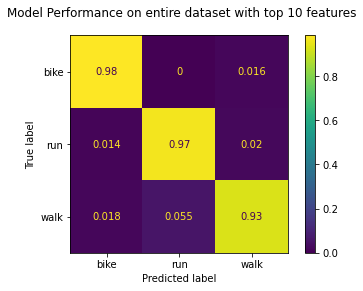

In [345]:
## Final model and its performance
print('Best model using full dataset and top 10 features:')
print('Max Depth (max_depth)=%s, Number of Trees in the Forest (n_estimators)=%s ' 
      % (result10.best_params_['max_depth'],result10.best_params_['n_estimators']))      
print('Estimated accuracy (entire dataset)=%.3f, Average estimated Accuracy from logo=%.3f (%.3f)' 
      % (estimate_final10, np.mean(accuracy_test10), np.std(accuracy_test10)))

disp = ConfusionMatrixDisplay.from_predictions(labels, y10_logo_pred, normalize='true') 
disp.figure_.suptitle("Model Performance from logo cv (Test) with top 10 features");

disp = ConfusionMatrixDisplay.from_predictions(labels, y10_pred, normalize='true') 
disp.figure_.suptitle("Model Performance on entire dataset with top 10 features");

Now we see an overall increase in the generalized (logo) and all dataset accuracy. This is due to an increase in accuracy in classifying walk to 89% (from 81%), with only 6.4% being misclassified as run. 

Let's see if this improvement is visible on the classification plot.

C:\Users\d_all\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\d_all\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 611 samples in 0.017s...
[t-SNE] Computed neighbors for 611 samples in 0.030s...
[t-SNE] Computed conditional probabilities for sample 611 / 611
[t-SNE] Mean sigma: 0.279568
[t-SNE] KL divergence after 250 iterations with early exaggeration: 49.283199
[t-SNE] KL divergence after 300 iterations: 0.256155


C:\Users\d_all\AppData\Local\Temp/ipykernel_10496/1836599157.py:14: UserWarning: The following kwargs were not used by contour: 'lw'
  plt.tricontourf(X_tsne[:,0],X_tsne[:,1],y10_pred2,levels=[0.5,1.5],lw=0.5,cmap =  my_cmap, alpha =0.3,extend="both")


Text(0.5, 1.0, 't-NSE Decision Boundary of the best model using the top 10 features')

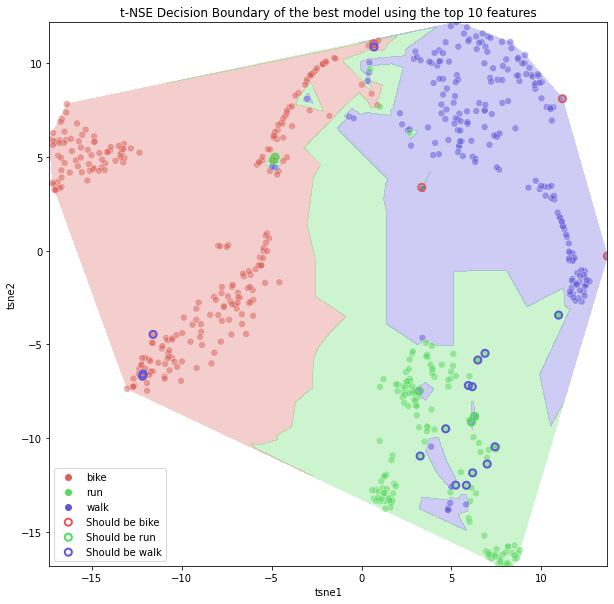

In [346]:
##### TSNE projection to keep the top 2 components for 2D scatter plots

tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300);
X_tsne = tsne.fit_transform(features10)
df_tsne = pd.DataFrame(X_tsne,columns=["tsne1","tsne2"]) 

plt.figure(figsize=(10,10))

# plot first decision boundary regions
y10_pred2 = np.empty(np.size(y10_pred))
for i,label in enumerate(class_names):
    y10_pred2[y10_pred==label]=i
    
plt.tricontourf(X_tsne[:,0],X_tsne[:,1],y10_pred2,levels=[0.5,1.5],lw=0.5,cmap =  my_cmap, alpha =0.3,extend="both")    

# then the predicted datapoints 

ax = sns.scatterplot(x="tsne1", y="tsne2",data=df_tsne,
                hue=y10_pred, palette=palette,hue_order=hue_order,
                legend="full", s=50, alpha=0.5)

# finally highlight incorrectly labeled data with an outer colored edge around the marker
for i,label in enumerate(class_names): #= np.array(['bike', 'run', 'walk'])
    plt.scatter(X_tsne[(y10_pred!=labels) & (labels==label), 0], X_tsne[(y10_pred!=labels) & (labels==label), 1],
            s=50, facecolor = 'none', edgecolor=palette[i],marker="o",lw=2,label="Should be "+label)

ax.legend()
ax.set_title('t-NSE Decision Boundary of the best model using the top 10 features')

Walk remains one class that has isolated points within and gets mainly misclassified as run. Let's check to whom these misclassified points belongs to!

In [347]:
print(pd.DataFrame(zip(subjects[y10_pred!=labels],labels[y10_pred!=labels],y10_pred[y10_pred!=labels]),
                   columns=('Subject','Class','Predicted')))

   Subject Class Predicted
0       s3  bike      walk
1       s3  bike      walk
2       s3  bike      walk
3       s3  bike      walk
4       s3   run      walk
5       s6   run      bike
6       s6   run      bike
7       s6   run      walk
8       s6   run      walk
9       s6  walk      bike
10      s6  walk      bike
11      s6  walk      bike
12      s6  walk       run
13      s6  walk       run
14      s6  walk       run
15      s6  walk       run
16      s6  walk       run
17      s6  walk       run
18      s6  walk       run
19      s6  walk       run
20      s6  walk       run
21      s6  walk       run
22      s6  walk       run
23      s6  walk       run
24      s8  walk      bike


As suspected (as it had the worst classification accuracy in the logo cv), most misclassification are for s6. In particular, "walk" (whose raw data was very noisy and atypical) are often being misclassified as "run", . 

## Overall Conclusion

In summary, our model using a grid search for hyperparameter tuning on a Random Forest Classifier, led to reasonable accuracy of 91.3% which was slightly improved to 92.5% when reducing features to 10. 
The model was having difficulties classifying subject 6 activities who had very atypical raw data especially for "walk".

This dataset suffered from having an imbalanced data, with limited number of subjects and who didn't performed all 3 activities. As such, this result may not be well generalizeable. The visual representation of the classification performance suggests that the current model suffer from some overfitting. This could be further addressed which may reduce overall accuracy but may narrow the gap between test and training accuracy suggesting better generalizibility of the results.